In [1]:
import pandas as pd
import numpy as np

from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.svm import SVC

from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.feature_selection import SelectFromModel

from preprocessing import  limpiar_datos, aplicar_dummy_variables_encoding, eliminar_features, entrenar_iterative_imputer, imputar_missings_iterative, reduccion_PCA, normalizar_dataframe, entrenar_normalizador_standard, entrenar_normalizador_minmax
from graficos_modelos import mostrar_reporte_clasificacion, graficar_auc_roc,graficar_matriz_confusion
from funciones_auxiliares import traer_datasets, traer_dataset_prediccion_final, separar_dataset, encontrar_hiperparametros_RGSCV, mapear_target_binario

# Support Vector Machines

### Obtención de los datos

In [2]:
df, df_sin_target, solo_target = traer_datasets()

X_train, X_test, y_train, y_test = separar_dataset(df_sin_target, solo_target)

X_train.is_copy=False
X_test.is_copy=False
y_train.is_copy=False
y_test.is_copy=False

y_train.set_index('id', inplace=True)
y_train = y_train.sort_values(by=['id'], ascending=True).copy()

y_test.set_index('id', inplace=True)
y_test = y_test.sort_values(by=['id'], ascending=True).copy()


### Definiendo distintos preprocesamientos

Definiremos entonces dos preprocesamientos distintos a comparar para este modelo, y quedarnos con el mejor de ellos cuando probemos en holdout.

In [3]:
def preprocesamiento_1(df_original:pd.DataFrame, imputer=None, normalizador=None):
    df = df_original.copy(deep=True)
    df = limpiar_datos(df)
    df = aplicar_dummy_variables_encoding(df, ['llovieron_hamburguesas_hoy'])
    eliminar_features(df, ['dia','barrio', 'direccion_viento_tarde', 'direccion_viento_temprano', 'rafaga_viento_max_direccion'])
    
    if(imputer is None):
        imputer = entrenar_iterative_imputer(df)
    df = imputar_missings_iterative(df, imputer)
    
    if(normalizador is None):
        normalizador = entrenar_normalizador_minmax(df)
    df = normalizar_dataframe(df, normalizador)
    
    return df, imputer, normalizador

Vemos que el primero de ellos primero corrije los datos con formato erróneo del dataset, como por ejemplo direcciones IP registradas en la feature 'presion_atmosférica_tarde', o datos que deberían ser NaNs pero son whitespace. Luego se aplica dummy encoding a la única feature categórica que nos resultó importante del análisis en el TP1. Pasamos a eliminar el resto de features categóricas y completamos los missings con el IterativeImputer. Finalmente aplicamos en este procesamiento un MinMaxScaler provisto por sklearn.

In [4]:
def preprocesamiento_2(df_original:pd.DataFrame, imputer=None, normalizador=None, seleccion_lasso=None):
    df = df_original.copy(deep=True)
    df = limpiar_datos(df)
    eliminar_features(df, ['dia']) #eliminamos el día pues al tener alta cardinalidad de valores no sería sabio convertirla, y no tenemos indicativos de que sea importante para la predicción desde el TP1.
    df = aplicar_dummy_variables_encoding(df, ['llovieron_hamburguesas_hoy', 'barrio', 'direccion_viento_tarde', 'direccion_viento_temprano', 'rafaga_viento_max_direccion'])
    
    if(imputer is None):
        imputer = entrenar_iterative_imputer(df)
    df = imputar_missings_iterative(df, imputer)
    
    if(seleccion_lasso is None):
        sel = SelectFromModel(LogisticRegression(C=1, penalty='l1', solver='liblinear', max_iter=1000))
        sel.fit(df, y_train.to_numpy().ravel())
        seleccion_lasso = df.columns[(sel.get_support())]
    
    eliminar_features(df,df.columns.difference(seleccion_lasso))
    
    if(normalizador is None):
        normalizador = entrenar_normalizador_standard(df)
    df = normalizar_dataframe(df, normalizador)
    
    return df, imputer, normalizador, seleccion_lasso

El segundo preprocesamiento primero corrije los datos con formato erróneo del dataset, como por ejemplo direcciones IP registradas en la feature 'presion_atmosférica_tarde', o datos que deberían ser NaNs pero son whitespace. Luego se aplica dummy encoding a todas las features categóricas. Una vez hecho esto, completamos los missings con el IterativeImputer y además aplicaremos una normalización estándar que puede ser beneficiosa en SVM.
Luego decidimos aplicar una regresión con función de pérdida Lasso como método de selección de atributos. Gracias a esta selección, podemos droppear del dataframes aquellas features que RandomForest no haya considerado importante para terminar el preprocesamiento.

### Aplicamos preprocesamientos 1 y 2 para obtener X_train_1 / X_test_1 y X_train_2 / X_test_2 respectivamente

In [5]:
X_train_1, imputer_entrenado_1, normalizador_1 = preprocesamiento_1(X_train)
X_test_1, imputer_entrenado_1, normalizador_1 = preprocesamiento_1(X_test, imputer_entrenado_1, normalizador_1)

In [6]:
X_train_2, imputer_entrenado_2, normalizador_2, seleccion_lasso = preprocesamiento_2(X_train)
X_test_2, imputer_entrenado_2, normalizador_2, seleccion_lasso = preprocesamiento_2(X_test, imputer_entrenado_2, normalizador_2, seleccion_lasso)

c:\users\juan cruz\appdata\local\programs\python\python38\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


### Búsqueda de Hiperparámetros para el modelo que entrenará sobre X_train_1

Buscamos hiperparámetros con RandomGridSearch, pues GridSearch iterativamente es bastante lento. En el caso de SVM, estos serán 'C' (dureza ante outliers), 'kernel' (el kernel a utilizar para evitar problemas linealmente inseparables), 'degree' (grado del kernel polinomial, ignorado por los otros kernels) y  'max_iter' (el número máximo de iteraciones como criterio de paro).

In [7]:
params = {'C': [0.1, 1, 10], 'kernel': ['poly', 'rbf', 'sigmoid'], 'degree':[2,3,4], 'max_iter':[20000]}
hiperparametros = encontrar_hiperparametros_RGSCV(SVC(), params=params, x_np=X_train_1, y_np=y_train.to_numpy().ravel())

c:\users\juan cruz\appdata\local\programs\python\python38\lib\site-packages\sklearn\model_selection\_search.py:278: UserWarning: The total space of parameters 27 is smaller than n_iter=100. Running 27 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\users\juan cruz\appdata\local\programs\python\python38\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


In [8]:
c_elegido_1 = hiperparametros['C']
grado_elegido_1 = hiperparametros['degree']
kernel_elegido_1 = hiperparametros['kernel']
print(f'Mejor C: {c_elegido_1}')
print(f'Mejor kernel: {kernel_elegido_1}')
print(f'Mejor grado para kernel polinomial: {grado_elegido_1}')

Mejor C: 0.1
Mejor kernel: poly
Mejor grado para kernel polinomial: 2


### Entrenando el Modelo 1 sobre X_train_1 con CrossValidation

Procedemos a testear con kfolds, stratificados pues nuestro dataset es desbalanceado. Además, usamos los hiperparámetros encontrados previamente.

In [9]:
kf = StratifiedKFold(n_splits=5)
for fold_idx, (train_index, test_index) in enumerate(kf.split(X_train_1, y_train)):
    svm_clasificacion = SVC(max_iter=20000, C=c_elegido_1, kernel=kernel_elegido_1, degree=grado_elegido_1)
    svm_clasificacion.fit(X_train_1[train_index], y_train.iloc[train_index])
    print ('Reporte para el FOLD ' + str(fold_idx))
    print(classification_report(y_train.iloc[test_index], svm_clasificacion.predict(X_train_1[test_index]), target_names=['No llueven hamburguesas al dia siguiente', 'Llueven hamburguesas al dia siguiente']))
    

c:\users\juan cruz\appdata\local\programs\python\python38\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
c:\users\juan cruz\appdata\local\programs\python\python38\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


Reporte para el FOLD 0
                                          precision    recall  f1-score   support

No llueven hamburguesas al dia siguiente       0.85      0.96      0.90     15891
   Llueven hamburguesas al dia siguiente       0.77      0.42      0.54      4581

                                accuracy                           0.84     20472
                               macro avg       0.81      0.69      0.72     20472
                            weighted avg       0.83      0.84      0.82     20472



c:\users\juan cruz\appdata\local\programs\python\python38\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
c:\users\juan cruz\appdata\local\programs\python\python38\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


Reporte para el FOLD 1
                                          precision    recall  f1-score   support

No llueven hamburguesas al dia siguiente       0.87      0.93      0.90     15891
   Llueven hamburguesas al dia siguiente       0.67      0.51      0.58      4580

                                accuracy                           0.83     20471
                               macro avg       0.77      0.72      0.74     20471
                            weighted avg       0.82      0.83      0.82     20471



c:\users\juan cruz\appdata\local\programs\python\python38\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
c:\users\juan cruz\appdata\local\programs\python\python38\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


Reporte para el FOLD 2
                                          precision    recall  f1-score   support

No llueven hamburguesas al dia siguiente       0.85      0.96      0.90     15891
   Llueven hamburguesas al dia siguiente       0.75      0.43      0.55      4580

                                accuracy                           0.84     20471
                               macro avg       0.80      0.70      0.73     20471
                            weighted avg       0.83      0.84      0.82     20471



c:\users\juan cruz\appdata\local\programs\python\python38\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
c:\users\juan cruz\appdata\local\programs\python\python38\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


Reporte para el FOLD 3
                                          precision    recall  f1-score   support

No llueven hamburguesas al dia siguiente       0.85      0.97      0.91     15891
   Llueven hamburguesas al dia siguiente       0.82      0.41      0.55      4580

                                accuracy                           0.85     20471
                               macro avg       0.84      0.69      0.73     20471
                            weighted avg       0.85      0.85      0.83     20471



c:\users\juan cruz\appdata\local\programs\python\python38\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
c:\users\juan cruz\appdata\local\programs\python\python38\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


Reporte para el FOLD 4
                                          precision    recall  f1-score   support

No llueven hamburguesas al dia siguiente       0.85      0.97      0.91     15890
   Llueven hamburguesas al dia siguiente       0.82      0.41      0.54      4581

                                accuracy                           0.85     20471
                               macro avg       0.84      0.69      0.73     20471
                            weighted avg       0.84      0.85      0.83     20471



### Búsqueda de Hiperparámetros para el modelo que entrenará sobre X_train_2

Buscamos hiperparámetros con RandomGridSearch, pues GridSearch iterativamente es bastante lento. En el caso de SVM, estos serán 'C' (dureza ante outliers), 'kernel' (el kernel a utilizar para evitar problemas linealmente inseparables), 'degree' (grado del kernel polinomial, ignorado por los otros kernels) y  'max_iter' (el número máximo de iteraciones como criterio de paro).

In [10]:
params = {'C': [0.1, 1, 10], 'kernel': ['poly', 'rbf', 'sigmoid'], 'degree':[2,3,4], 'max_iter':[20000]}
hiperparametros = encontrar_hiperparametros_RGSCV(SVC(), params=params, x_np=X_train_2, y_np=y_train.to_numpy().ravel())

c:\users\juan cruz\appdata\local\programs\python\python38\lib\site-packages\sklearn\model_selection\_search.py:278: UserWarning: The total space of parameters 27 is smaller than n_iter=100. Running 27 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\users\juan cruz\appdata\local\programs\python\python38\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


In [11]:
c_elegido_2 = hiperparametros['C']
grado_elegido_2 = hiperparametros['degree']
kernel_elegido_2 = hiperparametros['kernel']
print(f'Mejor C: {c_elegido_2}')
print(f'Mejor kernel: {kernel_elegido_2}')
print(f'Mejor grado para kernel polinomial: {grado_elegido_2}')

Mejor C: 0.1
Mejor kernel: sigmoid
Mejor grado para kernel polinomial: 2


### Entrenando el Modelo 2 sobre X_train_2 con CrossValidation

Procedemos a testear con kfolds, stratificados pues nuestro dataset es desbalanceado. Además, usamos los hiperparámetros encontrados previamente.

In [12]:
kf = StratifiedKFold(n_splits=5)
for fold_idx, (train_index, test_index) in enumerate(kf.split(X_train_2, y_train)):
    svm_clasificacion = SVC(max_iter=20000, C=c_elegido_2, kernel=kernel_elegido_2, degree=grado_elegido_2)
    svm_clasificacion.fit(X_train_2[train_index], y_train.iloc[train_index])
    print ('Reporte para el FOLD ' + str(fold_idx))
    print(classification_report(y_train.iloc[test_index], svm_clasificacion.predict(X_train_2[test_index]), target_names=['No llueven hamburguesas al dia siguiente', 'Llueven hamburguesas al dia siguiente']))
    

c:\users\juan cruz\appdata\local\programs\python\python38\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
c:\users\juan cruz\appdata\local\programs\python\python38\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


Reporte para el FOLD 0
                                          precision    recall  f1-score   support

No llueven hamburguesas al dia siguiente       0.86      0.95      0.90     15891
   Llueven hamburguesas al dia siguiente       0.70      0.45      0.55      4581

                                accuracy                           0.83     20472
                               macro avg       0.78      0.70      0.72     20472
                            weighted avg       0.82      0.83      0.82     20472



c:\users\juan cruz\appdata\local\programs\python\python38\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
c:\users\juan cruz\appdata\local\programs\python\python38\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


Reporte para el FOLD 1
                                          precision    recall  f1-score   support

No llueven hamburguesas al dia siguiente       0.88      0.87      0.88     15891
   Llueven hamburguesas al dia siguiente       0.57      0.58      0.57      4580

                                accuracy                           0.81     20471
                               macro avg       0.72      0.73      0.73     20471
                            weighted avg       0.81      0.81      0.81     20471



c:\users\juan cruz\appdata\local\programs\python\python38\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
c:\users\juan cruz\appdata\local\programs\python\python38\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


Reporte para el FOLD 2
                                          precision    recall  f1-score   support

No llueven hamburguesas al dia siguiente       0.88      0.88      0.88     15891
   Llueven hamburguesas al dia siguiente       0.58      0.58      0.58      4580

                                accuracy                           0.81     20471
                               macro avg       0.73      0.73      0.73     20471
                            weighted avg       0.81      0.81      0.81     20471



c:\users\juan cruz\appdata\local\programs\python\python38\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
c:\users\juan cruz\appdata\local\programs\python\python38\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


Reporte para el FOLD 3
                                          precision    recall  f1-score   support

No llueven hamburguesas al dia siguiente       0.87      0.89      0.88     15891
   Llueven hamburguesas al dia siguiente       0.58      0.53      0.55      4580

                                accuracy                           0.81     20471
                               macro avg       0.72      0.71      0.72     20471
                            weighted avg       0.80      0.81      0.81     20471



c:\users\juan cruz\appdata\local\programs\python\python38\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
c:\users\juan cruz\appdata\local\programs\python\python38\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


Reporte para el FOLD 4
                                          precision    recall  f1-score   support

No llueven hamburguesas al dia siguiente       0.86      0.94      0.90     15890
   Llueven hamburguesas al dia siguiente       0.70      0.49      0.58      4581

                                accuracy                           0.84     20471
                               macro avg       0.78      0.72      0.74     20471
                            weighted avg       0.83      0.84      0.83     20471



### Predicción del modelo sobre holdout con el modelo que mejor resultó al hacer CrossValidation: Modelo 2

Podemos ver al comparar ambos procesos de CrossValidation, que en general el modelo que usó el preprocesamiento_2 resultó en mejores métricas provistas por el classification report. En promedio, apreciamos un recall mejor, y en consecuencia también un f1 score mucho mejor para este modelo. Vemos además que no hay manifestaciones de overfit, por lo que pasaremos a utilizar el Modelo 2 para predecir sobre el dataset de holdout.

In [13]:
svm_holdout = SVC(max_iter=50000, C=c_elegido_2, kernel=kernel_elegido_2, degree=grado_elegido_2, probability=True)
svm_holdout.fit(X_train_2, y_train.to_numpy().ravel())

SVC(C=0.1, degree=2, kernel='sigmoid', max_iter=50000, probability=True)

In [14]:
mapeo_binario_v = np.vectorize(mapear_target_binario)
y_pred = svm_holdout.predict(X_test_2)
y_pred_binario = mapeo_binario_v(y_pred)
y_pred_proba = svm_holdout.predict_proba(X_test_2)[:, 1]
y_test_binario = y_test['llovieron_hamburguesas_al_dia_siguiente'].map({'si': 1, 'no': 0}).to_numpy()
print(classification_report(y_test['llovieron_hamburguesas_al_dia_siguiente'].to_numpy(), y_pred))

              precision    recall  f1-score   support

          no       0.86      0.90      0.88      8828
          si       0.59      0.47      0.52      2545

    accuracy                           0.81     11373
   macro avg       0.72      0.69      0.70     11373
weighted avg       0.80      0.81      0.80     11373



### Curva AUC ROC


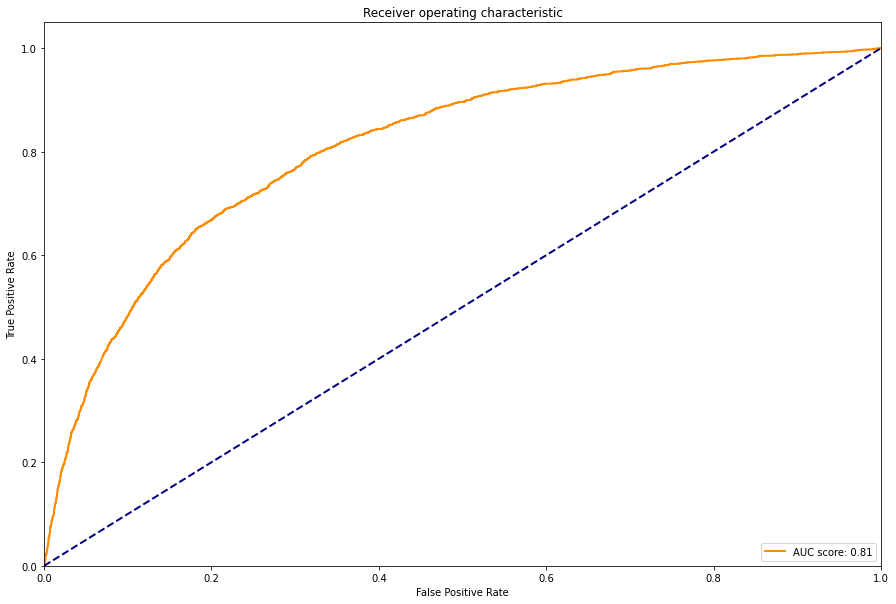

AUC-ROC para este modelo es: 0.8096867397270519


In [15]:
graficar_auc_roc(y_test_binario, y_pred_proba)

Podemos ver que a pesar de ser un buen AUC_SCORE, la curva se ve más bien achatada en comparación a otros modelos donde la curvatura cambia uniformemente. Las métricas en holdout resultaron muy similares a las del árbol en el clasification report, así que pasaremos a graficar la matriz de confusión para tener una mejor perspectiva

### Matriz de confusion

c:\users\juan cruz\appdata\local\programs\python\python38\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass labels=[0, 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


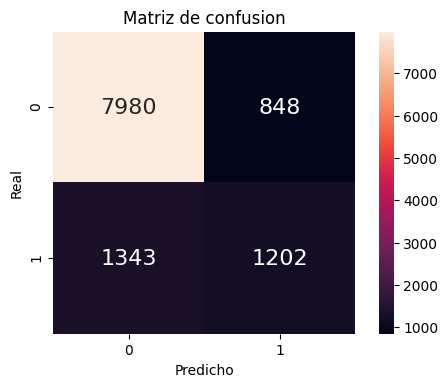

In [16]:
graficar_matriz_confusion(y_test_binario, y_pred_binario)

Seguimos teniendo dificultades en este modelo para alcanzar buenos valores de Recall, a pesar de tener en general una precision aceptable. Sin embargo creemos que las métricas resultantes en holdout siguen siendo aceptables para SVM y que todavía podremos obtener resultados aún mejores en otros modelos.

## Predicción con el dataset nuevo
A continuación, realizamos la predicción con el árbol sin expandir el dataset sobre el dataset de predicciones nuevo, y la escribimos al archivo 'SVM.csv'

In [17]:
from funciones_auxiliares import exportar_prediccion_final

df_prediccion_final = traer_dataset_prediccion_final()
ids = df_prediccion_final['id'].to_numpy()

df_prediccion_final, imputer_entrenado_2, normalizador_2, seleccion_lasso = preprocesamiento_2(df_prediccion_final, imputer_entrenado_2, normalizador_2, seleccion_lasso)
predicciones = svm_holdout.predict(df_prediccion_final)

exportar_prediccion_final(ids, predicciones, 'SVM')